Numerical Schemes for hyperbolic PDEs

First, we will establish a preliminary traffic density for our analysis.

In [1]:
import numpy as ny
from matplotlib import pyplot as py
%matplotlib inline

In [8]:
def red_light_rho(x, rho_max):
    
    # this function defines the initial rho condition
    rho = rho_max * ny.ones_like(x)
    mask = ny.where(x < 3.0)
    rho[mask] = 0.5 * rho_max
    return rho

In [10]:
# set parameters

nx = 81 #number of locations on road
L = 4.0 # length of road
dx = L / (nx -1) # distance between locations on road
nt = 40 # number of time steps to compute
rho_max = 10.0 # max traffic density allowed
u_max = 1.0 # max traffic speed

# get road locations
x = ny.linspace(0.0, L, num=nx)

rho_0 = red_light_rho(x, rho_max)

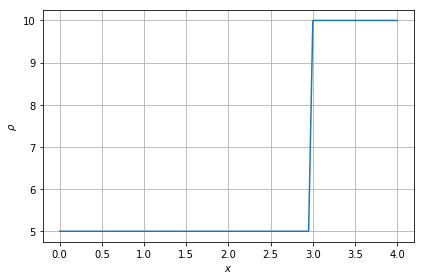

In [12]:
# plot of initial traffic density

fig = py.figure(figsize=(6.0, 4.0))
py.xlabel(r'$x$')
py.ylabel(r'$\rho$')
py.grid()
line = py.plot(x, rho_0)[0]
py.tight_layout()

so, if this is how the cars are accumulated at time 0, then we want to answer HOW THEY WILL ACCUMULATE OVER A CERTAIN AMOUNT OF TIME

in order to make helpful animations later, we can create some functions that will help

In [13]:
def flux(rho, u_max, rho_max):
    F = rho * u_max * (1.0 - rho / rho_max)
    return F

In [14]:
from matplotlib import animation
from IPython.display import HTML

In [15]:
def plot_update(n, rho_hist):
    
    fig.suptitle('time step {:0>2}'.format(n))
    line.set_ydata(rho_hist[n])

LAX-FRIEDRICHS SCHEME

In [16]:
def lax_friedrichs(rho_0, nt, dt, dx, bc_values, *args):
    
    rho_hist = [rho_0.copy()]
    rho = rho_0.copy()
    for n in range(nt):
        F = flux(rho, *args)
        # advance in time using Lax-Friedrichs
        rho[1:-1] = (0.5 * (rho[:-2] + rho[2:]) -
                    dt / (2.0 * dx) * (F[2:] - F[:-2]))
        
        # set the value for initial condition
        rho[0] = bc_values[0]
        # set the value at the last location
        rho[-1] = bc_values[1]
        # record the time-step solution
        rho_hist.append(rho.copy())
    return rho_hist


now we try with CFL of 1

In [17]:
sigma = 1.0
dt = sigma*dx / u_max # time-step size

# compute the traffic density at all time steps
rho_hist = lax_friedrichs(rho_0, nt, dt, dx, (rho_0[0], rho_0[-1]),
                         u_max, rho_max)

In [20]:
# create an animation of traffic density
anim = animation.FuncAnimation(fig, plot_update,
                              frames=nt, fargs =(rho_hist,),
                              interval=100)

#display video
HTML(anim.to_html5_video())

THINK

There is some obvious error as the line between the maximum traffic and the minimum traffic should a straight vertical line.

There is some 1st order error error, as there are small lines within the vertical line between the maximum and the minimum traffic densities.

So far, this scheme could use much more improvement.

Now, we will decrease the CFL number to 0.5 to show its affects by making the time steps smaller.

In [22]:
sigma = 0.5
dt = sigma * dx / u_max

rho_hist = lax_friedrichs(rho_0, nt, dt, dx, (rho_0[0], rho_0[-1]),
                         u_max, rho_max)

In [23]:
anim = animation.FuncAnimation(fig, plot_update,
                              frames=nt, fargs=(rho_hist,),
                              interval=100)

HTML(anim.to_html5_video())

The wave does not move nearly as much, and I believe the error was actually increased.

LAX-WENDROFF SCHEME

The first function that we have to define is the jacobian, which is delF over delrho, defined in the lesson.

In [24]:
def jacobian(rho, u_max, rho_max):
    
    J = u_max * (1.0 - 2.0 * rho / rho_max)
    return J

Now we will create a function that defines the lax wendroff approach. this function will incorporate the formula that is outlined in the lesson

In [25]:
def lax_wendroff(rho_0, nt, dt, dx, bc_values, *args):
    
    rho_hist = [rho_0.copy()]
    rho = rho_0.copy()
    for n in range(nt):
        F = flux(rho, *args) #compute flux
        J = jacobian(rho, *args) # compute jacobian
        rho[1:-1] = (rho[1:-1] - 
                    dt / (2.0 * dx) * (F[2:] - F[:-2]) +
                    dt**2 / (4.0 * dx**2) * 
                    ((J[1:-1] + J[2:]) * (F[2:] - F[1:-1]) -
                    (J[:-2] + J[1:-1]) * (F[1:-1] - F[:-2])))
        
        rho[0] = bc_values[0] # set value at the first location
        
        rho[-1] = bc_values[1] # set value at the last location
        
        rho_hist.append(rho.copy()) # record solution for time-step
    return rho_hist

now that we've created this function, we can use the cfl limit as we did before to create our time step and solution.

In [26]:
sigma = 1.0
dt = sigma * dx / u_max #time-step size

# compute traffic density at all time steps
rho_hist = lax_wendroff(rho_0, nt, dt, dx, (rho_0[0], rho_0[-1]),
                       u_max, rho_max)

In [28]:
# create an animation
anim = animation.FuncAnimation(fig, plot_update,
                              frames=nt, fargs=(rho_hist,),
                              interval=100)

#display video
HTML(anim.to_html5_video())

Now we'll check to see what occurs when we change the cfl condition to half of what it was before:

In [29]:
sigma = 0.5
dt = sigma * dx / u_max #time-step size

# compute the traffic density at all time
rho_hist = lax_wendroff(rho_0, nt, dt, dx, (rho_0[0], rho_0[-1]),
                       u_max, rho_max)

In [30]:
anim = animation.FuncAnimation(fig, plot_update,
                              frames=nt, fargs=(rho_hist,),
                              interval=100)

HTML(anim.to_html5_video()) # display the video

MACCORMACK SCHEME

this scheme allows you to compute problems with left-running waves and right-running waves and will provide a stable method.

In [31]:
def maccormack(rho_0, nt, dt, dx, bc_values, *args):
    
    rho_hist = [rho_0.copy()]
    rho = rho_0.copy()
    rho_first = rho.copy()
    for n in range(nt):
        F = flux(rho, *args) #compute flux
        rho_first[1:-1] = (rho[1:-1] - # predictor step
                          dt / dx * (F[2:] - F[1:-1]))
        #need to compute flux again for second step
        F = flux(rho_first, *args)
        rho[1:-1] = 0.5 * (rho[1:-1] + rho_first[1:-1] -
                          dt / dx * (F[1:-1] - F[:-2]))
        
        rho[0] = bc_values[0] # set value at first location
        rho[-1] = bc_values[1] # set value at last location
        
        #save the time-step solution
        rho_hist.append(rho.copy())
    return rho_hist

Now we'll set the CFL number to 1, so that we can evaluate the solution at this location

In [32]:
sigma = 1.0
dt = sigma * dx / u_max #time-step size

# compute traffic density at all time steps
rho_hist = maccormack(rho_0, nt, dt, dx ,(rho_0[0], rho_0[-1]),
                     u_max, rho_max)

In [33]:
# create animation of traffic density
anim = animation.FuncAnimation(fig, plot_update,
                              frames=nt, fargs=(rho_hist,),
                              interval=100)

#display video
HTML(anim.to_html5_video())

now we'll take a look again at how the CFL affects errors, by changing the CFL value to 0.5

In [34]:
sigma = 0.5
dt = sigma * dx / u_max #time-step size

#compute traffic density at all times

rho_hist = maccormack(rho_0, nt, dt, dx, (rho_0[0], rho_0[-1]),
                     u_max, rho_max)

In [35]:
anim = animation.FuncAnimation(fig, plot_update,
                              frames=nt, fargs=(rho_hist,),
                              interval=100)

In [36]:
HTML(anim.to_html5_video()) # display video